#**Average Pool Model**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the model architecture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(AveragePooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Add a flatten layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='linear'))

# Compile the model with 'mse' loss and Adam optimizer with a learning rate of 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Define the callback function to save the model
save_AveragePool_model = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5",
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
            
          
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
AveragePool_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_AveragePool_model])       
     
# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePool_model_history.pkl', 'wb') as f:
    pickle.dump(AveragePool_model_history.history, f)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 3068.2808 - accuracy: 0.6511
Epoch 1: accuracy improved from -inf to 0.65107, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5
62/62 [==============================] - 36s 508ms/step - loss: 3068.2808 - accuracy: 0.6511 - val_loss: 1115.5793 - val_accuracy: 0.7674
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 902.7848 - accuracy: 0.7947
Epoch 2: accuracy improved from 0.65107 to 0.79466, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5
62/62 [==============================] - 34s 563ms/step - loss: 902.7848 - accuracy: 0.7947 - val_loss: 887.2875 - val_accuracy: 0.7674
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 604.3066 - accuracy: 0.8393
Epoch 3: accuracy improved from 0.79466 to 0.83932, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-R

###**Test the model for detecting output**

In [ ]:
import matplotlib.pyplot as plt

#Load model
AveragePoolModel = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = AveragePoolModel.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set

validation_loss, validation_accuracy = AveragePoolModel.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = AveragePoolModel.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = AveragePoolModel.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 5s 277ms/step - loss: 831.7375 - accuracy: 0.7812
Validation Loss: 831.737548828125
Validation Accuracy: 0.78125
62/62 [==============================] - 19s 306ms/step - loss: 30.0478 - accuracy: 0.9507
Training Loss: 30.047800064086914
Training Accuracy: 0.9506612420082092
9/9 [==============================] - 2s 236ms/step - loss: 869.4995 - accuracy: 0.7766
Test loss: 869.49951171875
Test accuracy: 0.7765567898750305


###**Visual Representation on Training and Validation**

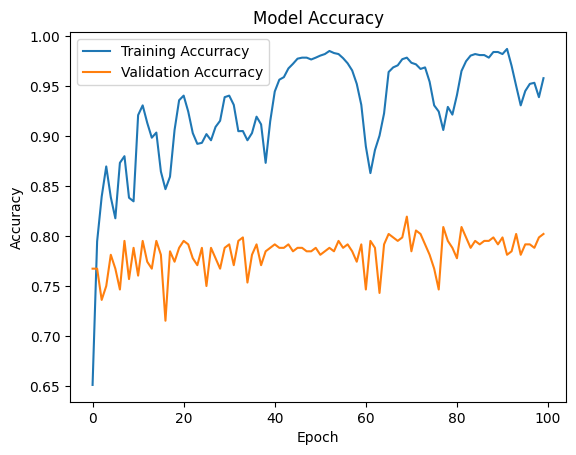

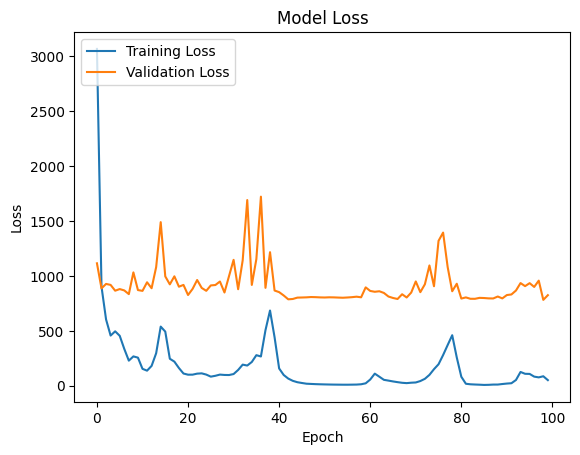

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePool_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
